# Clip spectral analysis

A `Clip` is used to work with a soundfile within the context of *maelzel.core*. It can be converted to and from a `maelzel.snd.audiosample.Sample` and can be subjected to different analysis strategies, both in the *time domain* (rms, autocorrelation, silence detection, onsets, etc) and the *frequency domain* (fundamental analysis and transcription, spectral analysis, etc). 

One of the most common use cases is to determine the **most prominent spectral contents of a sound at a given time**. When analyzing a sound, particularly an **inharmonic** one (a bell, a multiphonic, a low piano note) it might be interesting to analyze its overtones. Extracting overtones of a voice can give important information of its **formant structure**. 

This can be performed with the method `chordAt`, which analyzes a fragment of the clip and extracts the **most prominent frequencies** and their **corresponding amplitudes**

In [8]:
from maelzel.core import *
from pitchtools import *
from maelzel.snd.audiosample import Sample
from maelzel.snd import ampcomp
import numpy as np
import os

The *pitch* attribute is chosen arbitrarily and is only used for notation, it has no implications for playback

Clip(source=/home/em/dev/python/maelzel/notebooks/snd/colours-german-male.flac, numChannels=1, sr=44100, dur=None, resolvedDur=10.742812…, sourcedursecs=10.743secs)
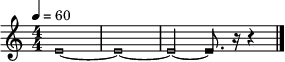

In [2]:
cl = Clip(os.path.abspath("../notebooks/snd/colours-german-male.flac"), pitch="4E")
cl

A `Clip` can be converted to a `Sample`

Sample(dur=10.74281179138322, sr=44100, ch=1)
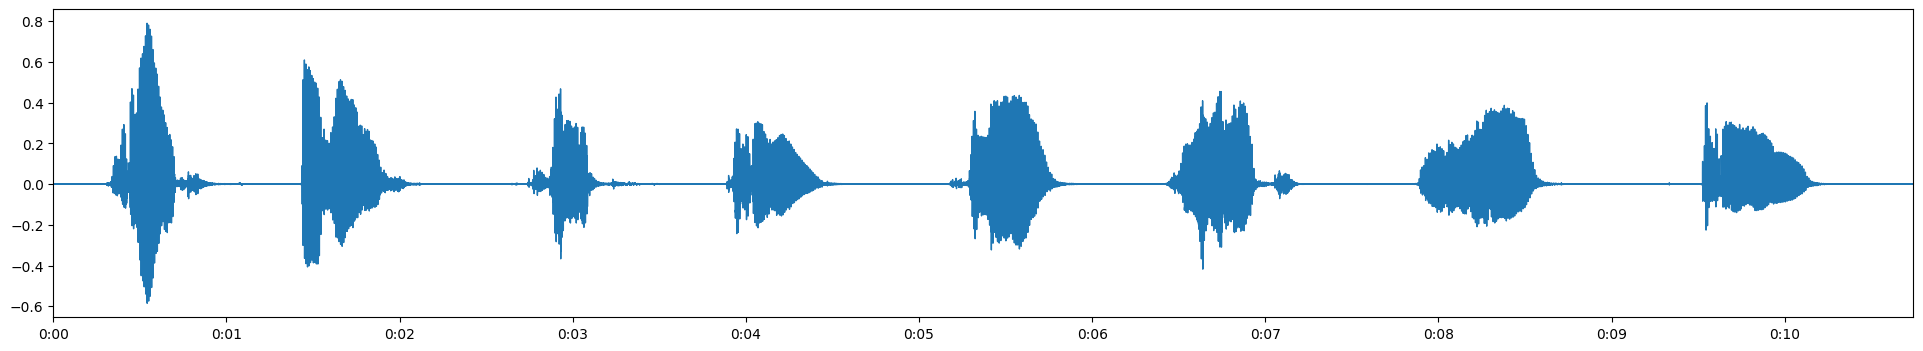

In [3]:
cl.asSample()

When displaying such big chords it is important to customize some settings. In particular displaying cents deviations for all notes in a chord can be visually distracting. Also to make rendering faster we disable enharmonic respelling

In [3]:
cfg = CoreConfig()
cfg['show.respellPitches'] = False
cfg['show.centsDeviationAsTextAnnotation'] = False
cfg['chordAdjustGain'] = False
cfg['show.voiceMaxStaves'] = 3
cfg.activate()

## Chord sequence based on overtones

The soundfile is analyzed 16 times per second (see *dt*). Only components louder than `-55dB` are taken into consideration. The number of components is further limited by the frequency range. From those components only the 8 loudest are selected and converted to a Chord

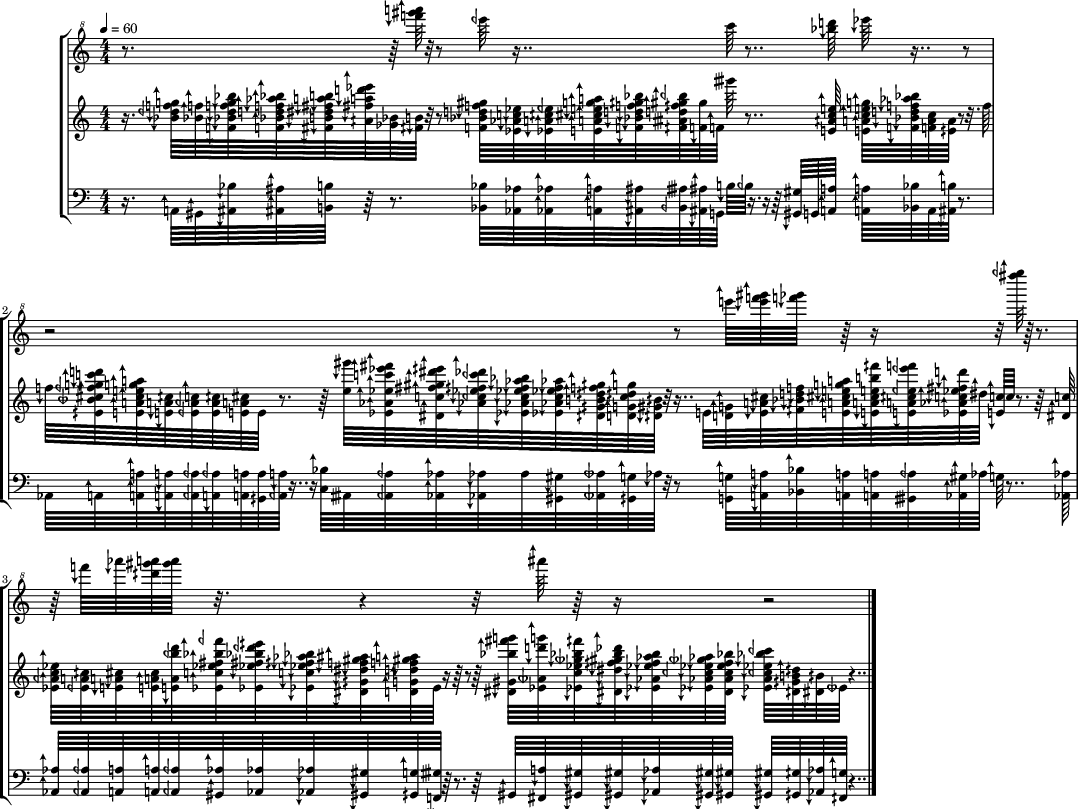

In [55]:
dt = 1/16
times = np.arange(0, cl.durSecs(), dt)
items = [cl.chordAt(t, mindb=-55, dur=dt, maxcount=8, ampfactor=10, maxfreq=m2f(126), minfreq=40) or Rest(dt) for t in times]
chain = Chain(items)
chain.show()


Synthesizing the chords with a sine tone results in a quite understandable if 'lo-fi' rendition

OfflineRenderer(sr=44100)
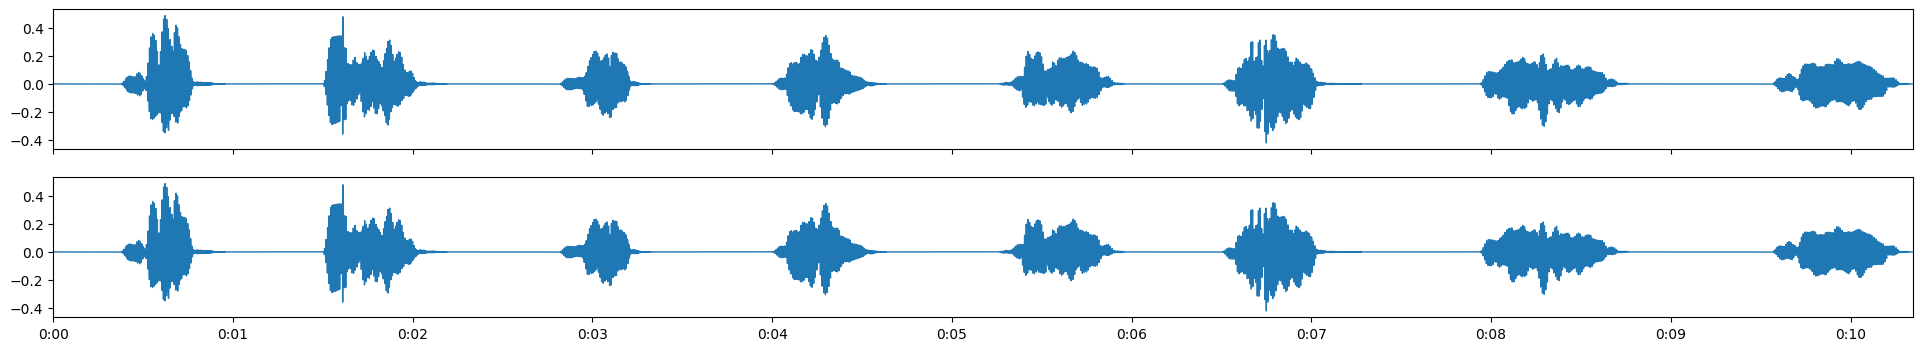

In [50]:
chain.rec(gain=0.2, instr='sin', fade=(0.05, 0.05), sustain=0.05, position=0.5)

The same sequence but rendered with a piano as instrument

OfflineRenderer(sr=44100)
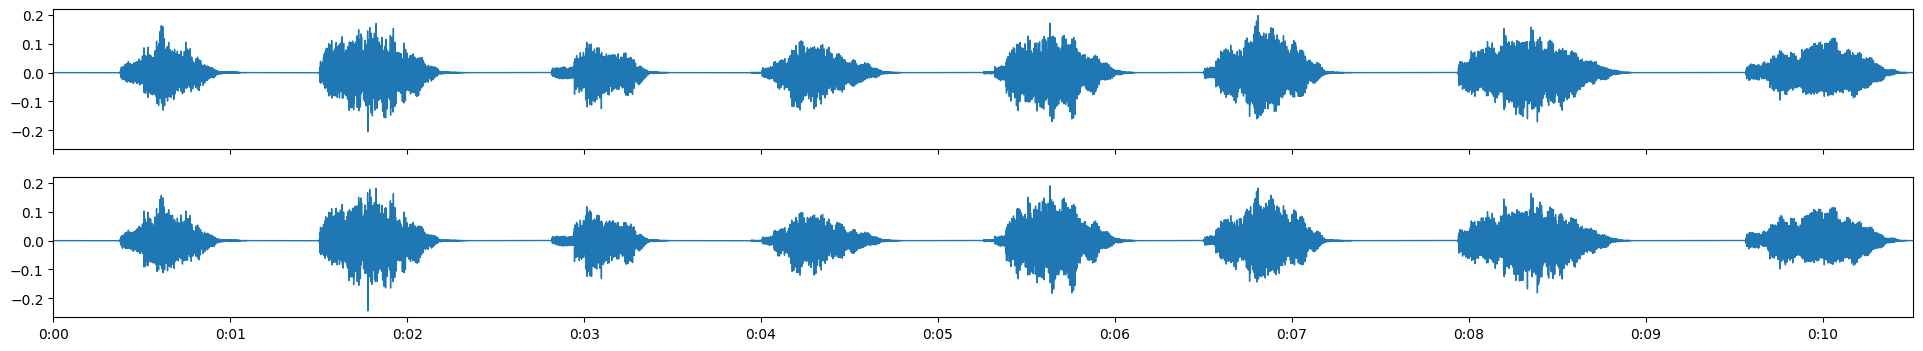

In [41]:
chain.rec(gain=0.2, instr='piano', fade=(0.01, 0.1), sustain=0.2)

A clearer result can be achieved by applying an inverse A-curve amplitude compensation. This makes the sound less saturated and more distinct

OfflineRenderer(sr=44100)
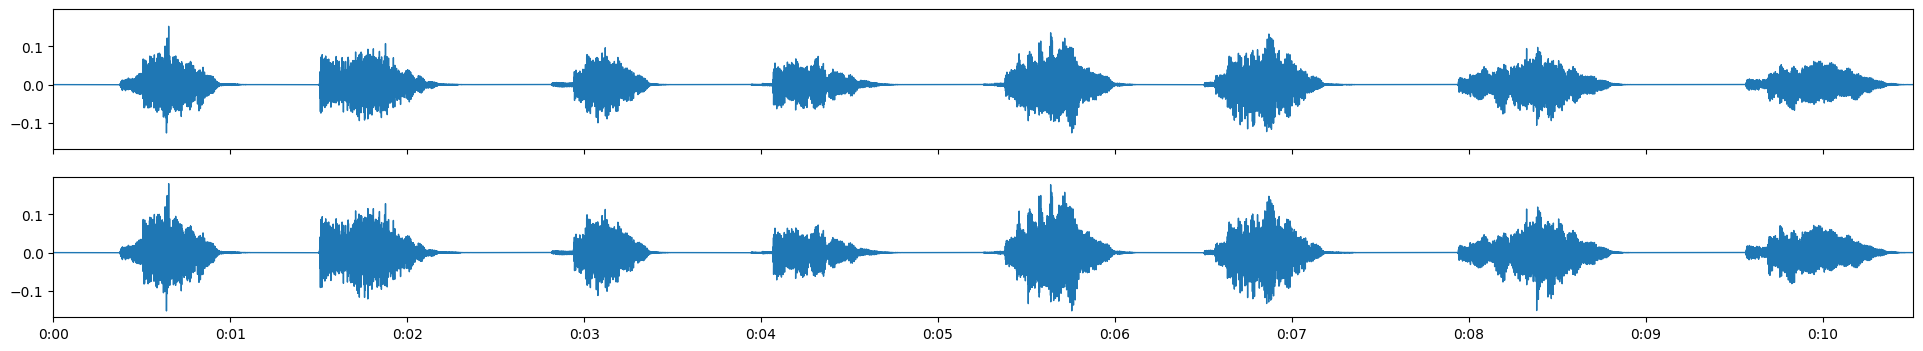

In [73]:
acurve = ampcomp.AmpcompA()
items2 = [item.copy() for item in items]
for item in items2:
    if isinstance(item, Chord):
        for n in item.notes:
            n.amp *= 1 - acurve.level(n.freq)
            n.amp *= 2
            
chainA = Chain(items2)
chainA.rec(gain=0.2, instr='piano', fade=(0.01, 0.1), sustain=0.2)

To validate the analysis we can play the generated chords along the original soundfile

OfflineRenderer(sr=44100)
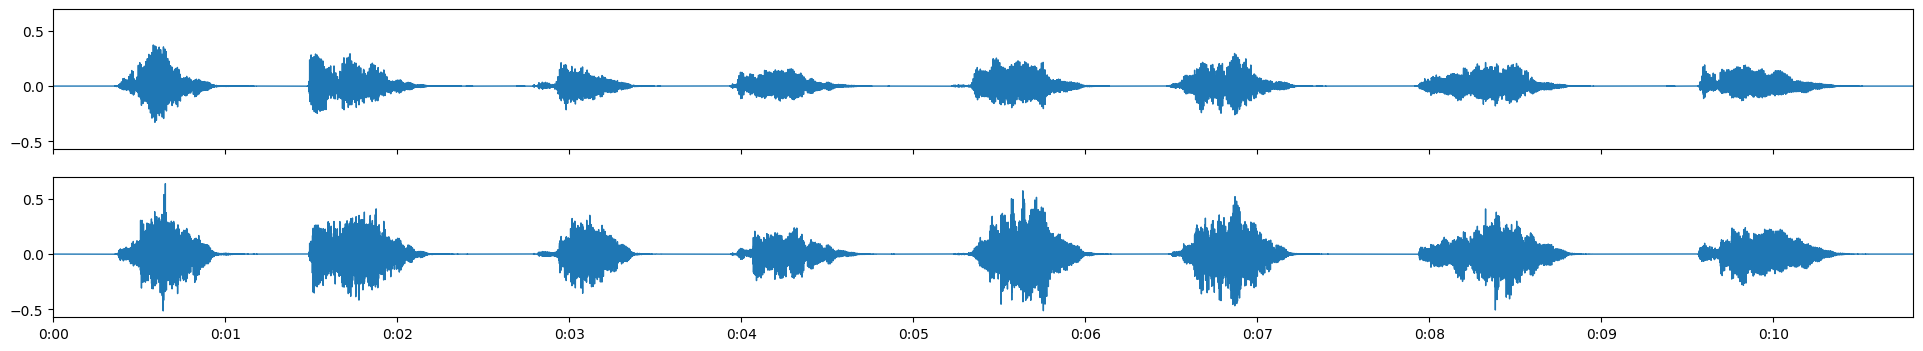

In [74]:
with render() as r:
    chainA.play(gain=0.5, instr='piano', fade=(0.01, 0.1), sustain=0.2, position=0.75)
    cl.play(position=0.25, gain=0.5, delay=0.05)
r

### Chromatic version

It is possible to make a version quantized to the nearest semitone. Notice when listening to the quantized version how the missing glissandi in the voice render the result much further away from the original

Chain([Rest:0.062♩, Rest:0.062♩, Rest:0.062♩, Rest:0.062♩, Rest:0.062♩, Rest:0.062♩, ‹2A 4Bb 5Db 5F 5G 0.0625♩›, ‹2Ab 4Bb 5F 0.0625♩›, ‹2Bb 3Bb 4F 4Bb 5D 5F 5G 5Bb 0.0625♩›, ‹2Bb 3Bb 4F 4Bb 5D 5F 5Ab 5Bb 0.0625♩›, …])
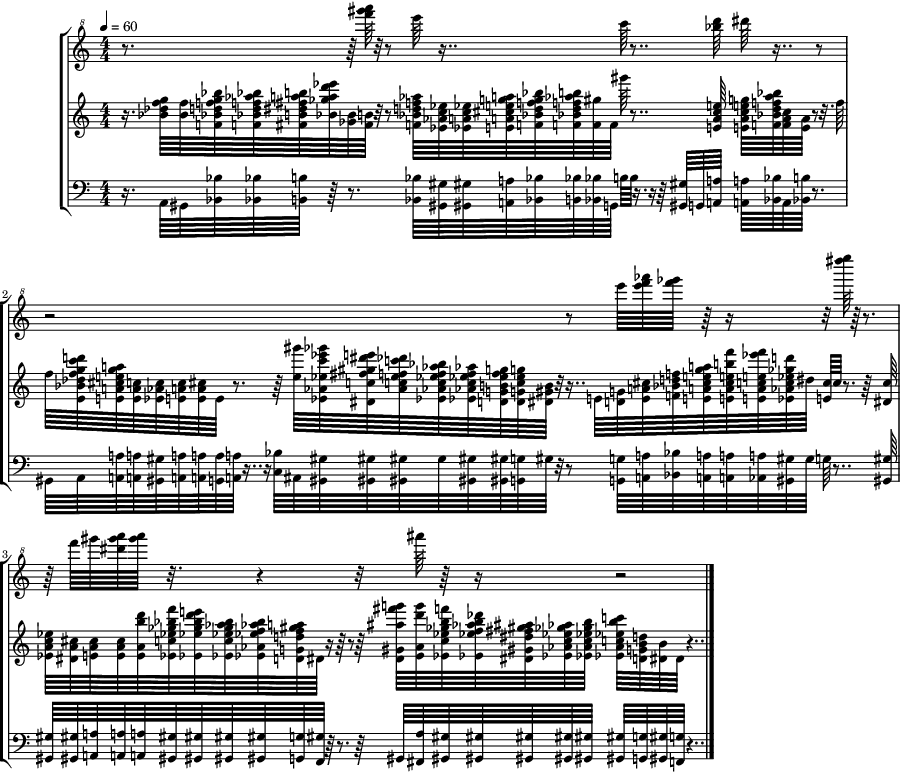

In [75]:
chain2 = chain.quantizePitch(step=1)
chain2

OfflineRenderer(sr=44100)
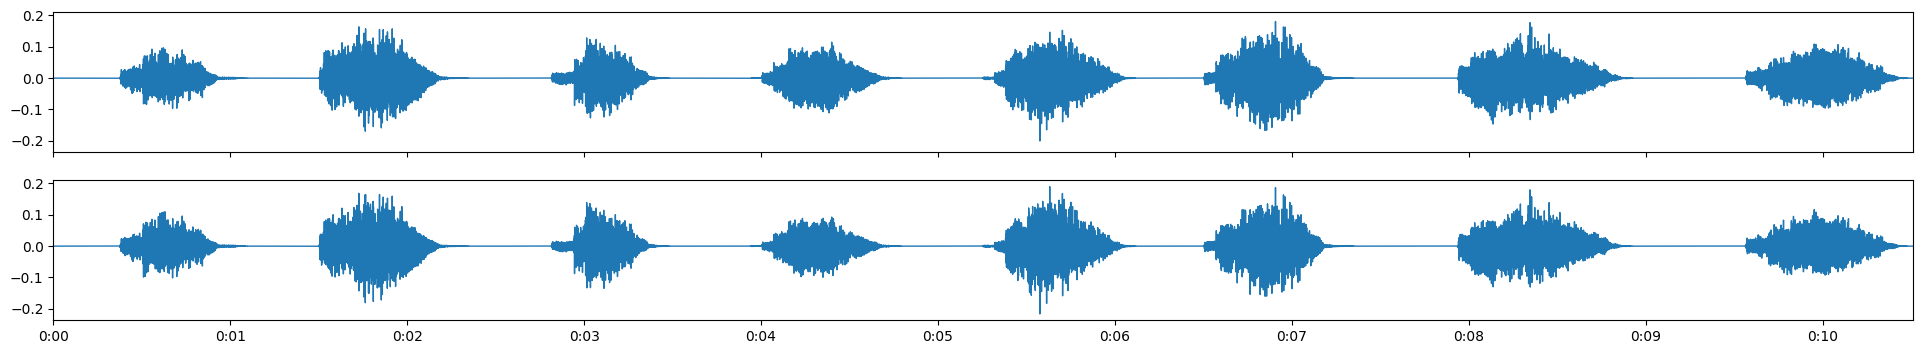

In [76]:
chain2.rec(gain=0.2, instr='piano', fade=(0.01, 0.1), sustain=0.2)

It is also possible to modify the time resolution, to produce other kinds of pixelation. In this case reducing the analysis to 8 times per second makes the rendition hardly recognizable

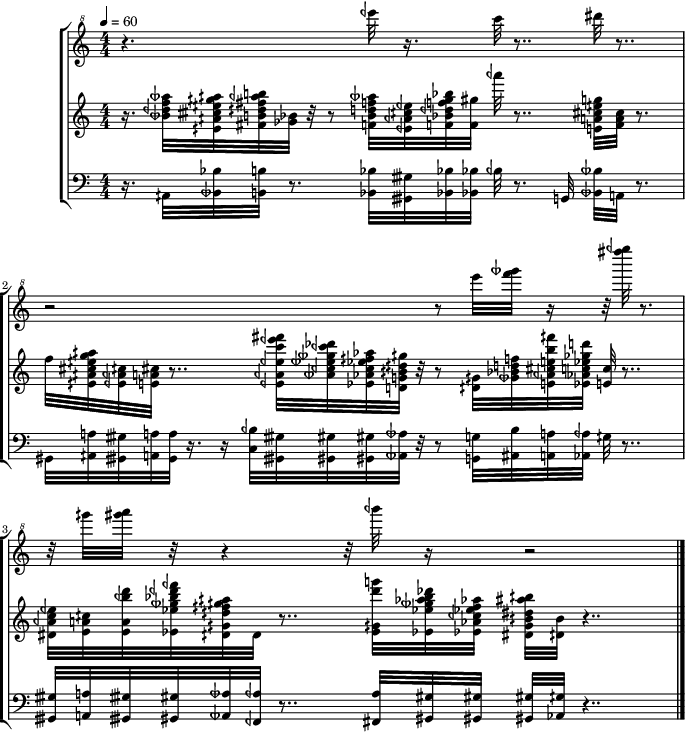

In [77]:
dt = 1/8
times = np.arange(0, cl.durSecs(), dt)
chords = [cl.chordAt(t, mindb=-55, dur=dt, maxcount=8, ampfactor=10, maxfreq=m2f(126), minfreq=40) or Rest(dt) for t in times]
chain3 = Chain(chords)
chain3 = chain3.quantizePitch(step=0.5)
chain3.show()

Just for the sake of variation we can try rendering using an accordion soundfont

OfflineRenderer(sr=44100)
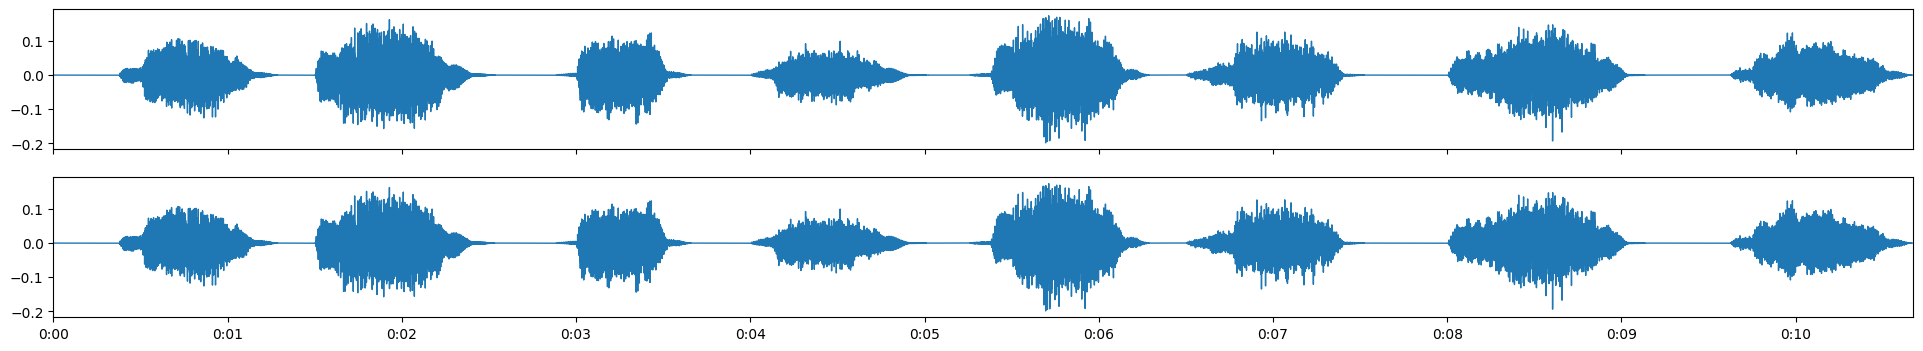

In [85]:
chain3.rec(gain=0.2, instr='accordion', fade=(0.01, 0.3), sustain=0.3)